<a href="https://colab.research.google.com/github/Damthe123/prueba/blob/main/2GCM_CMIP6_INDICES_CAMBIOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/jotabruno/CLIMATE_CHANGE_CMIP6/blob/main/1GCM_CMIP6_INDICES_CAMBIOS.ipynb
)


In [17]:
# Librerias requeridas para instalar, usamos pip
!pip install -q intake intake-esm xarray netcdf4 zarr cartopy shapely pyproj fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp
!pip install xmip
!pip install matplotlib
!pip install aiohttp requests
!pip install Cartopy
!pip install icclim


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rechunker 0.5.4 requires zarr<3,>=2.11, but you have zarr 3.1.5 which is incompatible.
  Using cached zarr-2.18.7-py3-none-any.whl.metadata (5.8 kB)
Using cached zarr-2.18.7-py3-none-any.whl (211 kB)
  Attempting uninstall: zarr
    Found existing installation: zarr 3.1.5
    Uninstalling zarr-3.1.5:
      Successfully uninstalled zarr-3.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kerchunk 0.2.9 requires zarr>=3.0.1, but you have zarr 2.18.7 which is incompatible.


In [18]:
import intake
import matplotlib.pyplot as plt
import xmip
from xmip.preprocessing import combined_preprocessing
import gcsfs
import numpy as np
import random
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import icclim
import xarray as xr
import xclim.core.calendar as xcal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from xmip.preprocessing import combined_preprocessing
import fsspec
fsspec.config.conf["gcs"] = {"token": "anon"}

In [19]:
# Parche xclim/icclim (si tu xclim no tiene convert_calendar)
# =========================================================
try:
    import xclim.core.calendar as xcal
    if not hasattr(xcal, "convert_calendar"):
        def convert_calendar(source, target, align_on=None, missing=None, dim="time"):
            return source.convert_calendar(calendar=target, dim=dim, align_on=align_on, missing=missing)
        xcal.convert_calendar = convert_calendar
except Exception:
    pass

In [20]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(cat_url)

In [21]:
# Filtramos el catálogo para una variable, tabla, experimento y modelo específicos
cat8 = cat.search(
    variable_id = 'pr',        # precipitacion
    table_id = 'day',          # datos diarios
    experiment_id = 'historical',
    source_id = ['MPI-ESM1-2-HR'],      # modelo

    member_id = ['r1i1p1f1'],      # miembro
    grid_label = 'gn'
)
# Mostramos el DataFrame resultante con los metadatos filtrados
# 2. Abrir todos los modelos
# ==============================
ds_dict_full_historical_pr = cat8.to_dataset_dict(
    zarr_kwargs={"consolidated": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [22]:
# Filtramos el catálogo para una variable, tabla, experimento y modelo específicos
cat6 = cat.search(
    variable_id = 'pr',        # precipitacion
    table_id = 'day',          # datos diarios
    experiment_id = 'ssp585',  # simulación ssp585
    source_id = ['MPI-ESM1-2-HR'],      # modelo
    member_id = ['r1i1p1f1'],      # miembro
    grid_label = 'gn'
)
# Mostramos el DataFrame resultante con los metadatos filtrados
# 2. Abrir todos los modelos
# ==============================
ds_dict_full_ssp585_pr = cat6.to_dataset_dict(
    zarr_kwargs={"consolidated": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/usr/local/lib/python3.12/dist-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 504. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/usr/local/lib/python3.12/dist-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 182. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/usr/local/lib/python3.12/dist-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 364. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)


In [23]:
# =========================================================
# CONFIG
# =========================================================
country = "Peru"
pad_deg = 1.2

t0_hist, t1_hist = "1981-01-01", "2010-12-31"
t0_fut,  t1_fut  = "2036-01-01", "2065-12-31"

proj = ccrs.PlateCarree()

# % cambio (como tu ejemplo)
vmin, vmax = -50, 50
ticks = np.arange(vmin, vmax + 1, 10)

# Colormap: verde (neg) -> blanco -> naranja (pos)
cmap = LinearSegmentedColormap.from_list("g_w_o", ["#1a9850", "#ffffff", "#d95f0e"])
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

In [24]:
# UTILIDADES
# =========================================================
def extent_from_country(country_name, pad_deg=1.0, resolution="10m"):
    shp = shapereader.natural_earth(resolution=resolution, category="cultural", name="admin_0_countries")
    geoms = [r.geometry for r in shapereader.Reader(shp).records() if r.attributes.get("ADMIN") == country_name]
    if not geoms:
        raise ValueError(f"No encontré el país: {country_name}")

    minx = min(g.bounds[0] for g in geoms)
    miny = min(g.bounds[1] for g in geoms)
    maxx = max(g.bounds[2] for g in geoms)
    maxy = max(g.bounds[3] for g in geoms)
    extent = (minx - pad_deg, maxx + pad_deg, miny - pad_deg, maxy + pad_deg)
    return extent, geoms

def adm1_lines(country_name, resolution="10m"):
    shp = shapereader.natural_earth(resolution=resolution, category="cultural", name="admin_1_states_provinces_lines")
    geoms = []
    for r in shapereader.Reader(shp).records():
        a = r.attributes
        if a.get("adm0_name") == country_name or a.get("ADM0_NAME") == country_name:
            geoms.append(r.geometry)
    return geoms

def sel_time_safe(da, t0, t1):
    da = da.sortby("time")
    try:
        return da.sel(time=slice(t0, t1))
    except Exception:
        y0, y1 = int(t0[:4]), int(t1[:4])
        return da.where((da["time"].dt.year >= y0) & (da["time"].dt.year <= y1), drop=True)

def prep_pr(da_pr, extent, t0, t1):
    # tiempo
    da_pr = sel_time_safe(da_pr, t0, t1)
    if da_pr.sizes.get("time", 0) == 0:
        return None

    # lon 0–360 -> -180–180
    if da_pr.lon.max() > 180:
        da_pr = da_pr.assign_coords(lon=((da_pr.lon + 180) % 360) - 180).sortby("lon")

    # recorte país
    lon_min, lon_max, lat_min, lat_max = extent
    da_pr = da_pr.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    if da_pr.sizes.get("lon", 0) == 0 or da_pr.sizes.get("lat", 0) == 0:
        return None

    # unidades: kg m-2 s-1 -> mm/day
    u = str(da_pr.attrs.get("units", "")).lower()
    if ("kg" in u and "s" in u) or ("kg m-2 s-1" in u) or ("kg m-2 s**-1" in u):
        da_pr = da_pr * 86400.0
        da_pr.attrs = dict(da_pr.attrs)
        da_pr.attrs["units"] = "mm/day"
    da_pr.name = "pr"
    return da_pr

def _to_da(out):
    if isinstance(out, xr.Dataset):
        return out[list(out.data_vars)[0]]
    return out

def index_mean_map(pr_da, index_name):
    # anual: devuelve serie anual del índice -> luego climatología (mean time)
    out = icclim.index(
        in_files=pr_da,
        index_name=index_name,
        slice_mode="year",
        ignore_Feb29th=True,
        logs_verbosity="LOW",
    )
    da = _to_da(out)
    if "time" in da.dims and da.sizes.get("time", 0) > 0:
        da = da.mean("time", skipna=True)
    return da

def pct_change(fut, hist):
    # (fut-hist)/hist*100, evitando /0
    return xr.where(np.isfinite(hist) & (hist != 0), (fut - hist) / hist * 100.0, np.nan)

# =========================================================
# TOMAR EL ÚNICO MODELO (MPI-ESM1-2-HR) DE TUS DICCIONARIOS
# =========================================================
ds_hist = list(ds_dict_full_historical_pr.values())[0]
ds_fut  = list(ds_dict_full_ssp585_pr.values())[0]

extent, country_geoms = extent_from_country(country, pad_deg=pad_deg, resolution="10m")
adm1_geoms = adm1_lines(country, resolution="10m")

pr_hist = prep_pr(ds_hist["pr"].squeeze(), extent, t0_hist, t1_hist)
pr_fut  = prep_pr(ds_fut["pr"].squeeze(),  extent, t0_fut,  t1_fut)

if pr_hist is None or pr_fut is None:
    raise RuntimeError("Recorte/tiempo quedó vacío. Revisa rangos de tiempo, lon/lat y que 'pr' tenga datos.")

# =========================================================
# ÍNDICES (ANUAL) + CAMBIO PORCENTUAL
# =========================================================
idx_list = [("SDII", "SDII (%)"), ("R10mm", "R10 (%)")]

#CDD Máximo de días secos consecutivos (Precipitación < 1 mm)
#CWD Máximo de días húmedos consecutivos (Precipitación >= 1 mm)
# PRCPTOT Precipitación total durante los días húmedos
# SDII Precipitación promedio durante los días húmedos (SDII)
# RX1day Precipitación máxima en 1 día
# RX5day Precipitación máxima en 5 días
# R20mm Número de días con precipitaciones intensas (Precip >= 20 mm)
# R10mm Número de días de precipitaciones intensas (Precip >=10mm)


delta_maps = {}
for idx, _ in idx_list:
    hist_map = index_mean_map(pr_hist, idx)
    fut_map  = index_mean_map(pr_fut,  idx)
    delta_maps[idx] = pct_change(fut_map, hist_map)

INFO:root:--- icclim 7.0.4
INFO:root:--- BEGIN EXECUTION
INFO:root:Processing: 0%
INFO:root:Processing: 100%
INFO:root:--- icclim 7.0.4
INFO:root:--- CPU SECS = 3037.696  
INFO:root:--- END EXECUTION
INFO:root:--- icclim 7.0.4
INFO:root:--- BEGIN EXECUTION
INFO:root:Processing: 0%
INFO:root:Processing: 100%
INFO:root:--- icclim 7.0.4
INFO:root:--- CPU SECS = 3038.594  
INFO:root:--- END EXECUTION
INFO:root:--- icclim 7.0.4
INFO:root:--- BEGIN EXECUTION
INFO:root:Processing: 0%
INFO:root:Processing: 100%
INFO:root:--- icclim 7.0.4
INFO:root:--- CPU SECS = 3039.171  
INFO:root:--- END EXECUTION
INFO:root:--- icclim 7.0.4
INFO:root:--- BEGIN EXECUTION
INFO:root:Processing: 0%
INFO:root:Processing: 100%
INFO:root:--- icclim 7.0.4
INFO:root:--- CPU SECS = 3040.132  
INFO:root:--- END EXECUTION


In [25]:
# =========================================================
# TOMAR EL ÚNICO MODELO (MPI-ESM1-2-HR) DE TUS DICCIONARIOS
# =========================================================
ds_hist = list(ds_dict_full_historical_pr.values())[0]
ds_fut  = list(ds_dict_full_ssp585_pr.values())[0]

extent, country_geoms = extent_from_country(country, pad_deg=pad_deg, resolution="10m")
adm1_geoms = adm1_lines(country, resolution="10m")

pr_hist = prep_pr(ds_hist["pr"].squeeze(), extent, t0_hist, t1_hist)
pr_fut  = prep_pr(ds_fut["pr"].squeeze(),  extent, t0_fut,  t1_fut)

if pr_hist is None or pr_fut is None:
    raise RuntimeError("Recorte/tiempo quedó vacío. Revisa rangos de tiempo, lon/lat y que 'pr' tenga datos.")

# =========================================================
# ÍNDICES (ANUAL) + CAMBIO PORCENTUAL
# =========================================================
idx_list = [("SDII", "SDII (%)"), ("R10mm", "R10 (%)")]

delta_maps = {}
for idx, _ in idx_list:
    hist_map = index_mean_map(pr_hist, idx)
    fut_map  = index_mean_map(pr_fut,  idx)
    delta_maps[idx] = pct_change(fut_map, hist_map)


INFO:root:--- icclim 7.0.4
INFO:root:--- BEGIN EXECUTION
INFO:root:Processing: 0%
INFO:root:Processing: 100%
INFO:root:--- icclim 7.0.4
INFO:root:--- CPU SECS = 3046.755  
INFO:root:--- END EXECUTION
INFO:root:--- icclim 7.0.4
INFO:root:--- BEGIN EXECUTION
INFO:root:Processing: 0%
INFO:root:Processing: 100%
INFO:root:--- icclim 7.0.4
INFO:root:--- CPU SECS = 3047.510  
INFO:root:--- END EXECUTION
INFO:root:--- icclim 7.0.4
INFO:root:--- BEGIN EXECUTION
INFO:root:Processing: 0%
INFO:root:Processing: 100%
INFO:root:--- icclim 7.0.4
INFO:root:--- CPU SECS = 3048.388  
INFO:root:--- END EXECUTION
INFO:root:--- icclim 7.0.4
INFO:root:--- BEGIN EXECUTION
INFO:root:Processing: 0%
INFO:root:Processing: 100%
INFO:root:--- icclim 7.0.4
INFO:root:--- CPU SECS = 3048.891  
INFO:root:--- END EXECUTION


KeyboardInterrupt: 

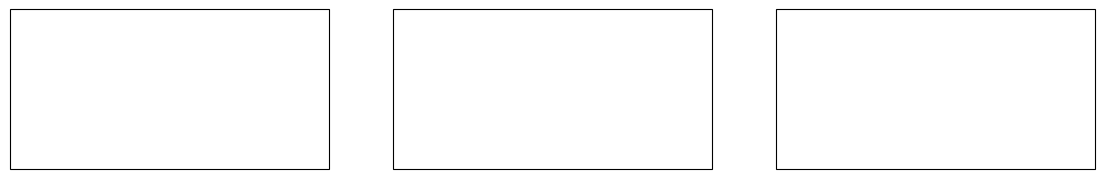

In [26]:
# =========================================================
# PLOT 1x3 (como tu ejemplo)
# =========================================================
fig, axes = plt.subplots(1, 3, figsize=(14, 5), subplot_kw={"projection": proj})
im = None

for ax, (idx, label) in zip(axes, idx_list):
    da = delta_maps[idx]

    im = ax.pcolormesh(
        da["lon"], da["lat"], da,
        transform=proj,
        shading="auto",
        cmap=cmap,
        norm=norm
    )

    ax.set_extent(extent, crs=proj)

    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor="lightgray", zorder=0)

    ax.coastlines(resolution="110m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # borde país
    ax.add_geometries(country_geoms, crs=proj, facecolor="none",
                      edgecolor="black", linewidth=1.6, zorder=3)

    # líneas internas (admin_1)
    if adm1_geoms:
        ax.add_geometries(adm1_geoms, crs=proj, facecolor="none",
                          edgecolor="black", linewidth=0.8, zorder=3)

    ax.set_title(label, fontsize=11)

# Colorbar común
cax = fig.add_axes([0.28, 0.08, 0.44, 0.03])
cb = fig.colorbar(im, cax=cax, orientation="horizontal", ticks=ticks)
cb.set_label("Cambio porcentual (%) = (2036–2065 − 1981–2010) / 1981–2010 × 100")

fig.suptitle(f"Cambio porcentual de índices de precipitación (ssp585 − histórico) – {country}\n2036–2065 vs 1981–2010",
             fontsize=13)

out = f"delta_pct_CDD_CWD_R20_{country}_ssp585_2036_2065_vs_1981_2010.png"
fig.savefig(out, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()